# First class functionalities Bern 2018 AWS & LCD Reference Sensors

This notebook uses a class framework to analyze sensor data from the 2018 aws and lcd data set. the end result is a monthly box plot.

In [18]:
# code set-up

# Import statements
import pandas as pd
import os
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.dates import MonthLocator

# Directories for reading and writing data
thedir = os.getcwd()
writedir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/interim'))
extdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'data/external'))
figdir = os.path.abspath(os.path.join(os.path.dirname(thedir), '..', 'figures'))

In [19]:
# load the data files (note the loading process for other data sets is in scratch.py)

# data with metadata from 2018 Bern Stadtklima study
data_be = pd.read_csv(F'{extdir}/2018_Stadtklimamessnetz_Rohdaten.csv')
data_be_meta = pd.read_csv(F'{extdir}/2018_Stadtklimamessnetz_Metadaten.csv')

# data without metadata from three closest automatic weather stations
data_test = pd.read_csv(F'{extdir}/ref_2018.csv')

In [20]:
# data corrections to fit into class objects. This is unique to each data set.

# metadata correction for Bern
# this block makes the metadata for the bern sensors easily readable into the class as dicts later on
def make_logger(x):
    data = 'Log_' + str(x)
    return data

def make_str(x):
    return str(x)

def get_city(x):
    if "Zoll" in x:
        return "Zollikofen"
    elif "Uett" in x:
        return "Uettligen"
    else:
        return "Bern"

data_be_meta['logger'] = data_be_meta.LogNr_2018.apply(lambda x: make_logger(x))
data_be_meta['gps_lat'] = data_be_meta.NORD_CHTOPO.apply(lambda x: make_str(x))
data_be_meta['gps_lon'] = data_be_meta.OST_CHTOPO.apply(lambda x: make_str(x))
data_be_meta['coord'] = '(' + data_be_meta.gps_lat + ',' + data_be_meta.gps_lon + ')'
data_be_meta.set_index('logger',inplace=True)
data_be_meta = data_be_meta[['coord','Name','ELEV_CHTOPO']].copy()
data_be_meta['city'] = data_be_meta.Name.apply(lambda x: get_city(x))

# correct bern 2018 metadata document to match bern 2018 data document
# column names do not match and Log_63/Log_64 each exist in only one file.
data_be['Log_63'] = data_be['Log_64']
data_be.drop(['Log_64'],axis = 1,inplace=True)
data_be['Log_83'] = data_be['Log_83_REF_AFU_3m']
data_be['Log_98'] = data_be['Log_98_REF_ZOLL_2m']
data_be['Log_99'] = data_be['Log_99_ZOLL_3m']
data_be['Log_999'] = data_be['Log_999_REF_ZOLL_HAUS']
data_be.drop(['Log_83_REF_AFU_3m','Log_98_REF_ZOLL_2m','Log_99_ZOLL_3m','Log_999_REF_ZOLL_HAUS'],axis = 1,inplace=True)

# correct date-time column for each set of loaded data

def fix_date_string(x):
    x = x[:10] + " " + x[11:-5]
    return x

data_be['md'] = pd.to_datetime(data_be['Zeit'], infer_datetime_format=True)
data_test['md'] = pd.to_datetime(data_test['Date_time_CET'], infer_datetime_format=True)

# split data for data test into low cost device and automatic weather stations
data_aws = data_test[['BOLL_AWS_TEMP', 'BOLL_PRECIP', 'BOLL_RADIATION_GLOBAL', 'BOLL_WIND_SPEED_mean','ZOLL_AWS_TEMP', 'ZOLL_RADIATION_GLOBAL', 'ZOLL_SUNSHINE', 'ZOLL_PRECIP', 
                   'ZOLL_WIND_SPEED_MEAN','AFU_AWS_TEMP', 'AFU_WIND_SPEED_MEAN', 'AFU_RADIATION_GLOBAL','md']]
data_lcd = data_test[['BOLL_LCD_TEMP','ZOLL_2m_LCD_TEMP',
       'ZOLL_3m_LCD_TEMP','md','AFU_LCD_TEMP','ZOLL_STEVENSON_LCD_TEMP']]

## Create sensor classes
This section reads in the sensor classes by chunk of data (biel data, bern data, archive_ data, opensensor data, reference data)

Note that the variables are instatiated as `None` as default

There is a base `Sensor` Class and four subclasses: `LowCostSensors AutoSensors OpenSensors archive_Sensors`

The class `LowCostSensors` is for the LCD sensors that this study is based around. `AutoSensors` are for the automatic weather station data. `OpenSensors` is for readings from the OpenSenseMap network. `archive_Sensors` are for data from the archive_.

In [21]:
# base sensor class inherited by the different sensor type subclasses
class Sensors:
    def __init__(self, project=None, year=None, name=None, city=None, sensor_type=None, data = None, qty=None, elev=None, coord=None, quant = None):
        self.project = project
        self.year = year
        self.name = name
        self.city = city
        self.data = data
        self.qty = qty
        self.sensor_type = sensor_type
        self.coord = coord
        self.elev = elev
        self.quant = quant
    
    # function to get specified interval date-time from each sensor instance
    def get_interval(self,interval):
        """
        takes 'h','d','m','y' as arguments for hours, days, months year aggregation
        """
        x = self.data
        if interval in ['h','d','m','y']:
            x[interval] = x.md.dt.to_period(interval)
            return x
        else:
            pass
    def get_basic_stats(self,stat_interval,to_melt):
        """
        takes 'h','d','m','y' as arguments for interval, 
        takes 'max','min','mean','var for stat desired
        """
        x = self.data
        data = x.groupby([stat_interval[1]]).agg(stat_interval[0])
        a = max(data.columns,key = len)
        data['sensor_type'] = self.sensor_type
        if to_melt:
            data['name'] = a
            data[stat_interval[0]] = data[a]
            data = data[[stat_interval[0],'name','sensor_type']].copy()
            return data
        else:
            return data[[a]]

In [22]:
# the two sensors class used here correspond to the AWS sensors and the LCD sensors

class AutoSensors(Sensors):
    ## basic stats functions
    def new_func():
        pass
    

class LowCostSensors(Sensors):
    def new_func():
        pass
    ## elevation and height corrections and Swiss Meteo corrections
    
    ## Radiation
    
    ## humidity
    
    # homogenization with Swiss meteo

In [23]:
# read in bern sensors for 2018

# get columns with data (all named "Log_X)
log_cols = [ x for x in data_be.columns if x[:3] == "Log" ]

# make metadata file into dictionary for ease of access
dict_city = data_be_meta['city'].to_dict()
dict_coord = data_be_meta['city'].to_dict()
dict_elev = data_be_meta['city'].to_dict()

# create a sensor object for each sensor in the datafile
mylist = []
for i in log_cols:
    data = data_be[['md',i]].copy()
    mylist.append(LowCostSensors('bern-temps',2021,i,dict_city[i],'lcd',data,'Temperature',dict_elev[i],dict_coord[i]))
bern_sensors = mylist

In [24]:
# read in bern aws data

# get data columns for each station in the test_data file
log_cols_z = [ x for x in data_aws.columns if x[:3] == "ZOL" ]
log_cols_b = [ x for x in data_aws.columns if x[:3] == "BOL" ]
log_cols_a = [ x for x in data_aws.columns if x[:3] == "AFU" ]
a = [log_cols_z,log_cols_b,log_cols_a]

# create a sensor object for each colum
mylist = []
for j in a:
    for i in j:
        data = data_aws[['md',i]].copy()
        if 'TEMP' in i:
            mylist.append(AutoSensors('bern-refs',2018,i,'Bern','aws',data,'Temperature'))
        elif 'WIND' in i:
            mylist.append(AutoSensors('bern-refs',2018,i,'Bern','aws',data,'Wind_Speed'))
        elif 'PRECIP' in i:
            mylist.append(AutoSensors('bern-refs',2018,i,'Bern','aws',data,'Precipitation'))
        elif 'RADI' in i:
            mylist.append(AutoSensors('bern-refs',2018,i,'Bern','aws',data,'Radiation'))
        elif 'SUNS' in i:
            mylist.append(AutoSensors('bern-refs',2018,i,'Bern','aws',data,'Sunshine'))
        
aws_sensors = mylist

## Showing Sensor data
Is the data what we expect?


In [25]:
print(F'There are {len(bern_sensors)} sensors total')
print(F'The first 5 rows of data of the first sensor object is:')
bern_sensors[0].data.head()

There are 83 sensors total
The first 5 rows of data of the first sensor object is:


,md,Log_1
0,2018-05-15 00:00:00,11.236
1,2018-05-15 00:10:00,11.139
2,2018-05-15 00:20:00,11.041
3,2018-05-15 00:30:00,10.944
4,2018-05-15 00:40:00,10.651


## First use of sensor objects
First data analysis using sensor objects. First we get aggregate the lists of sensors and then we create the time intervals for all sensors that we will use to aggregate the data. (days, months, hours). Printed is the first 5 rows of data from the first sensor - notice the new columns.

In [9]:
# get all sensors from the two lists
all_sensors = [x for y in [aws_sensors, bern_sensors] for x in y]
intervals = ['d','m','h','y']
values = ['max','min','var','mean']
# get month, day and hour intervals
summary_values = []
for i in intervals:
    [ x.get_interval(i) for x in all_sensors ]
print(F'There are {len(all_sensors)} total sensors')
all_sensors[0].data.head()

There are 95 total sensors


,md,ZOLL_AWS_TEMP,d,m,h,y
0,2018-05-16 00:00:00,10.8,2018-05-16,2018-05,2018-05-16 00:00,2018
1,2018-05-16 00:10:00,10.8,2018-05-16,2018-05,2018-05-16 00:00,2018
2,2018-05-16 00:20:00,10.8,2018-05-16,2018-05,2018-05-16 00:00,2018
3,2018-05-16 00:30:00,10.8,2018-05-16,2018-05,2018-05-16 00:00,2018
4,2018-05-16 00:40:00,10.8,2018-05-16,2018-05,2018-05-16 00:00,2018


## Create data classes
These classes will house the functions that wrangle the data. To start with we will make a combine_stats function that gets statistics over a given interval (daily mean, monthly min, etc) for any set of sensor data

In [10]:
class DataWrangle:
    """ Class to handle data from sensor classes. 
    Accepts a list of classes.
    Functions: get_stats based on passed tuple (stat,interval) e.g. ('max','d')
    for daily max or ('mean','m') for monthly mean
    """
    def __init__(self, sensors=None):
        self.sensors = sensors
    
 
    def get_stats(self,sensors_,stat_interval,to_melt):
        """   # this function calls the get_basic_stats() method built into the sensor class
        requires a tuple ('summary-stat','interval') for example ('mean','m') for monthly means
        returns a datafrane with data from one sensor
        """
        mylist = []
        for i in sensors_:
            b = i.get_basic_stats(stat_interval,to_melt)
            mylist.append(b)
        return mylist
        #self.get_basic_stats(stat,interval)
    
    def get_sensors(self,sensor_type,value_type):
        """
        Returns a list of sensors of the requested type (aws, lcd) and value (temp, wind, radiation, precip)
        """
        return [x for x in self.sensors if (x.sensor_type in sensor_type) & (x.qty in value_type)]
    
    def make_frame(self,sensor_type,value_type,stat_interval,to_melt):
        """
        Returns a list of dataframes of requested type (aws, lcd) and value (temp, wind, radiation, precip)
        aggregated according to the statistic and interval requested
        """
        target_sensors = self.get_sensors(sensor_type,value_type)
        data_list = self.get_stats(target_sensors,stat_interval,to_melt)
        return data_list
    
    def melt_frame(self,sensor_type,value_type,stat_interval,to_melt):
        """
        Returns a dataframe in long form suitable for plotting, accepts a list of dataframes
        """
        data = self.make_frame(sensor_type,value_type,stat_interval,to_melt)
        melted = pd.concat(data,axis = 0)
        return melted
    
    def get_overall(self,sensor_type,value_type,stat_interval,to_melt):
        data = self.make_frame(sensor_type,value_type,stat_interval,to_melt)
        all_data = pd.concat(data,axis=1)
        
        return all_data

In [11]:
# declare parameters we will use
intervals = ['d','m','h','y']
months = ['m','m','m','m']
values = ['max','min','mean','var']
stat_months = list(zip(values,months))
used_stats = ('mean','m')
value_types = ['Temperature']
sensor_types = ['aws','lcd']
# create instance of DataWrangle
wrangle = DataWrangle(all_sensors)

In [12]:
# mean monthly temps all devices
wrangled = wrangle.melt_frame(sensor_types,value_types,used_stats,True)


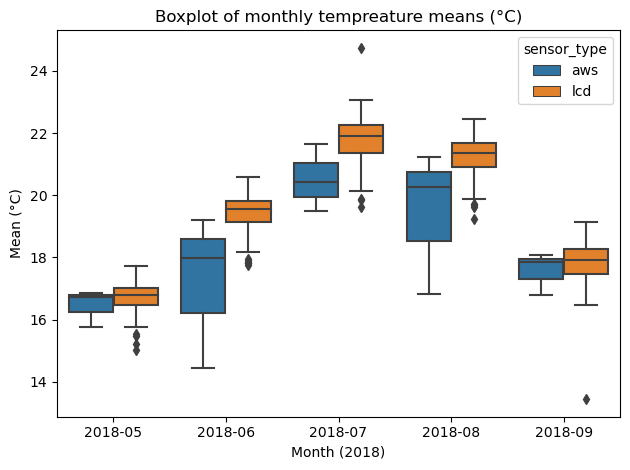

In [13]:
# monthly means of all
fig, axs = plt.subplots()
#locator = MonthLocator(interval=5)
sns.boxplot(data = wrangled,x=wrangled.index.astype(str),y=used_stats[0],hue = 'sensor_type')
plt.xlabel("Month (2018)")
plt.ylabel("Mean (°C)")
plt.title("Boxplot of monthly tempreature means (°C)")
plt.tight_layout()
plt.savefig(F'{figdir}/boxplot_2018_aws_lcd.png')
plt.show()

In [14]:
aws_temp = wrangle.get_sensors("aws",'Temperature')

In [15]:
lcd_temp = wrangle.get_sensors("lcd",'Temperature')


In [16]:
mynames = ["BOLL_LCD_TEMP","ZOLL_LCD_TEMP","AFU_LCD_TEMP"]
mylist = []
for i in lcd_temp:
    if i.name in mynames:
        mylist.append(i)
mylist
        
        

[]

In [17]:
used_stats = ('mean','m')
value_types = ['Wind_Speed']
sensor_types = ['aws','lcd']
wrangled_wind_mean = wrangle.melt_frame(sensor_types,value_types,used_stats,True)
used_stats = ('var','m')
value_types = ['Wind_Speed']
sensor_types = ['aws','lcd']
wrangled_wind_var = wrangle.melt_frame(sensor_types,value_types,used_stats,True)
wrangled_ = wrangle.get_overall(sensor_types,value_types,used_stats,False)
wrangled_wind_var
aws = [x for x in wrangled_.columns if "AWS" in x]
lcd = [x for x in wrangled_.columns if "Log" in x]
aws_ = wrangled_[aws]
lcd_ = wrangled_[lcd]
aws_mean = aws_.mean(axis=1)
lcd_mean = lcd_.mean(axis=1)
total = pd.DataFrame([aws_mean,lcd_mean])
total_ = total.transpose()
total_.columns = ['aws','lcd']
total_.reset_index(drop=False, inplace=True)
total_m = total_.melt('m',value_name="mean",var_name="sensor_type")
# variance of mean all devices
# declare parameters we will use
# get daily means all devices
used_stats = ('mean','m')
value_types = ['Temperature']
sensor_types = ['aws','lcd']
vdf = wrangle.get_overall(sensor_types,value_types,used_stats,False)

aws = [x for x in vdf.columns if "AWS" in x]

lcd = [x for x in vdf.columns if "Log" in x]
aws_ = vdf[aws].copy()
aws_['sensor_type'] = 'aws'
lcd_ = vdf[lcd].copy()
lcd_['sensor_type'] = 'lcd'

avar = aws_.var(axis=1,numeric_only=True)
amax = aws_.max(axis=1,numeric_only=True)
amin = aws_.min(axis=1,numeric_only=True)
amean = aws_.mean(axis=1,numeric_only=True)
lvar=lcd_.var(axis=1,numeric_only=True)
lmax=lcd_.max(axis=1,numeric_only=True)
lmin=lcd_.min(axis=1,numeric_only=True)
lmean=lcd_.mean(axis=1,numeric_only=True)

tot = pd.DataFrame([amax,amean,amin,lmax,lmean,lmin])
tot_ = tot.transpose()
tot_.columns = ['aws_max','aws_mean','aws_min','lcd_max','lcd_mean','lcd_min']
tot_.reset_index(drop=False, inplace=True)
tot_m = tot_.melt('m',value_name="Temperature",var_name="sensor_type")
mylist=[]
for i in tot_m.sensor_type:
    if "mean" in i:
        i = "mean"
        mylist.append(i)
    if "min" in i:
        i = "min"
        mylist.append(i)
    if "max" in i:
        i = "max"
        mylist.append(i)
tot_m["stat"] = mylist
mylist=[]
for i in tot_m.sensor_type:
    if "aws" in i:
        i = "aws"
        mylist.append(i)
    if "lcd" in i:
        i = "lcd"
        mylist.append(i)
tot_m["type"] = mylist